# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

<Client: 'tls://10.1.71.3:8786' processes=0 threads=0, memory=0 B>

In [77]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
import fastjmd95
import json

In [4]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [5]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)

In [6]:
#fix time dim (1896/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [7]:
ocean

<xarray.Dataset>
Dimensions:          (time: 1970, yt_ocean: 1070, xt_ocean: 1440, nv: 2,
                      st_ocean: 50, st_edges_ocean: 51, sw_edges_ocean: 51,
                      sw_ocean: 50, yu_ocean: 1070, xu_ocean: 1440)
Coordinates:
  * nv               (nv) float64 1.0 2.0
  * st_edges_ocean   (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean   (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean         (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time             (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean         (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.62 79.88
  * xu_ocean         (xu_ocean) float64 -279.8 -279.5 -279.2 ... 79.5 79.75 80.0
  * yt_ocean         (yt_ocean) float64 -80.02 -79.92 -79.81 ... 89.84 89.95
  * yu_ocean         (yu_ocean) float64 -79.97 -79.86 -79.76 ... 89.89 90.0
Data variables: (12/32)
    anompb           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    average_DT       (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    evap_heat        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hflux_cpl        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    ...               ...
    tauy             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    time_bounds      (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    u                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    v                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
    wt               (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 1070, 1440), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ocean_or_1993_01_04.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

In [8]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/SODA/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

#transport = open_ds('transport_wg.zarr')
cells = open_ds('cells_wg.zarr')
surf = open_ds('surf_terms.zarr')
totend = open_ds('totend.zarr')

In [9]:
path = 'pangeo-tmp/stb2145/models/SODA/'

transport = xr.open_zarr(gcfs_w_token.get_mapper(path + 'transport_wg.zarr'))

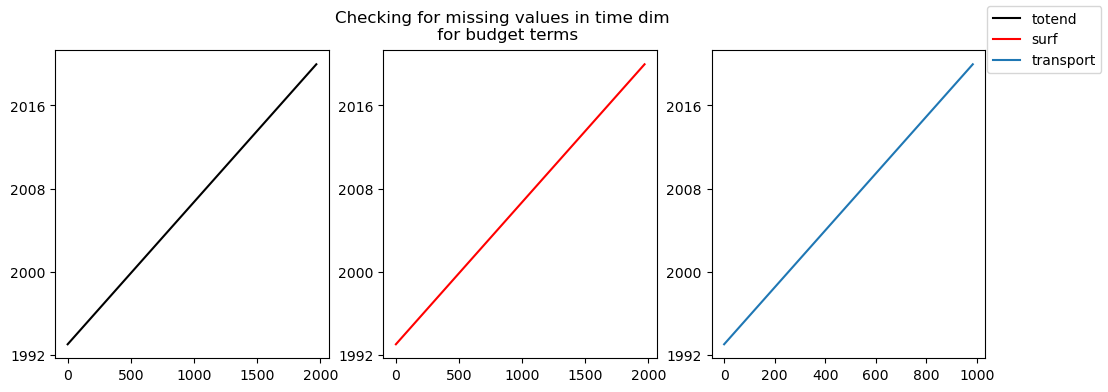

In [10]:
#check that time dim doesn't have missing value dates for budget terms
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(12,4))
ax0.plot(totend.time.values, label='totend', c='k') #every 5 days
ax1.plot(surf.time.values, label='surf', c='r') #every 5 days
ax2.plot(transport.time.values, label='transport') #every 10 days
plt.suptitle('Checking for missing values in time dim \n for budget terms')
fig.legend();

## <font color='Green'>Slice to WG region</font>

In [10]:
#WG boundaries (80˚S, 57˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 208 #right exclusive so it'll stop at -57.225204
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 208 #-57.15741334
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [11]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [12]:
ds_wg = ocean.isel(**lat_range, **lon_range)

In [13]:
ds_wg

<xarray.Dataset>
Dimensions:          (time: 1970, yt_ocean: 208, xt_ocean: 381, nv: 2,
                      st_ocean: 50, st_edges_ocean: 51, sw_edges_ocean: 51,
                      sw_ocean: 50, yu_ocean: 208, xu_ocean: 381)
Coordinates:
  * nv               (nv) float64 1.0 2.0
  * st_edges_ocean   (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean         (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean   (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean         (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time             (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean         (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.62 29.88
  * xu_ocean         (xu_ocean) float64 -65.0 -64.75 -64.5 ... 29.5 29.75 30.0
  * yt_ocean         (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.36 -57.23
  * yu_ocean         (yu_ocean) float64 -79.97 -79.86 -79.76 ... -57.29 -57.16
Data variables: (12/32)
    anompb           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 208, 381), meta=np.ndarray>
    average_DT       (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2       (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    evap_heat        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 208, 381), meta=np.ndarray>
    hflux_cpl        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 208, 381), meta=np.ndarray>
    ...               ...
    tauy             (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 208, 381), meta=np.ndarray>
    temp             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 208, 381), meta=np.ndarray>
    time_bounds      (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    u                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 208, 381), meta=np.ndarray>
    v                (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 50, 208, 381), meta=np.ndarray>
    wt               (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 208, 381), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ocean_or_1993_01_04.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

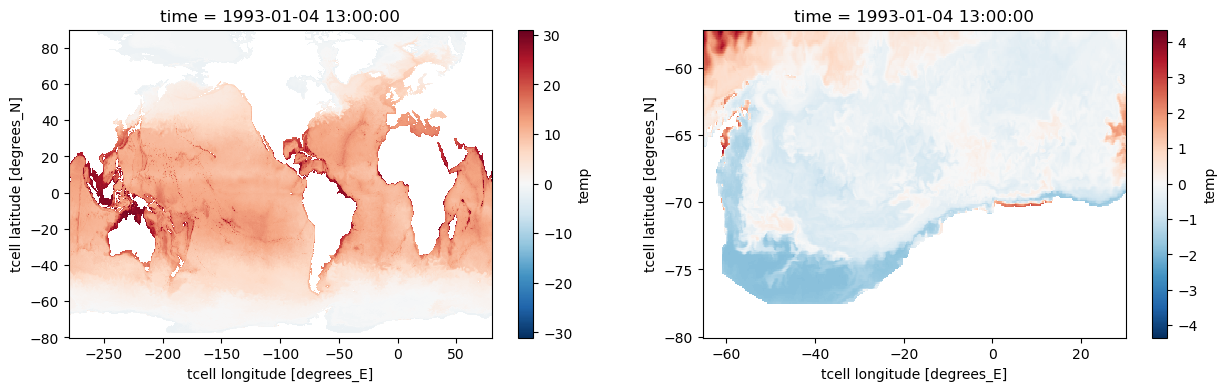

In [15]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
ocean.temp.mean('st_ocean')[0].plot(ax=ax0)
ds_wg.temp.mean('st_ocean')[0].plot(ax=ax1)

In [16]:
#mask our the acc in the corner
mask = xr.ones_like(ds_wg.temp[0])
mask1 = xr.ones_like(ds_wg.temp[0])

In [17]:
mask[:, 159:None, None:41] = 0
mask[:, 149:159, None:30] = 0
mask[:, 123:149, None:16] = 0
mask1[:, 123:None, None:30] = 0

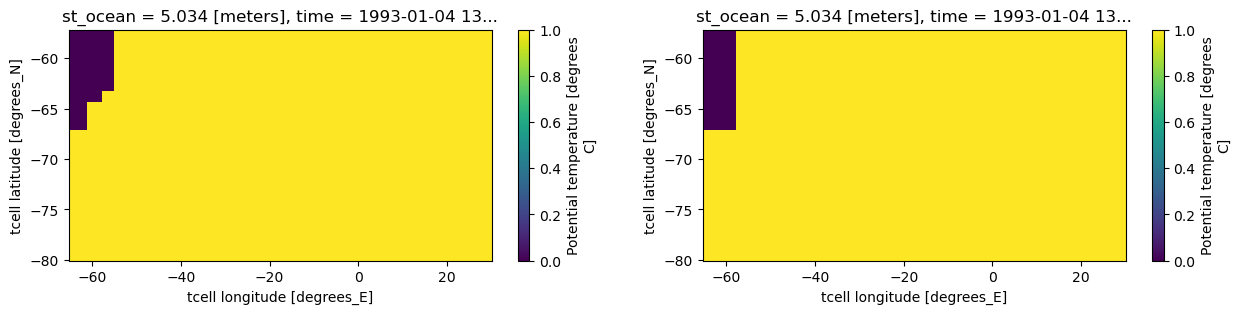

In [18]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,3))

mask[0].plot(ax=ax0)
mask1[0].plot(ax=ax1);

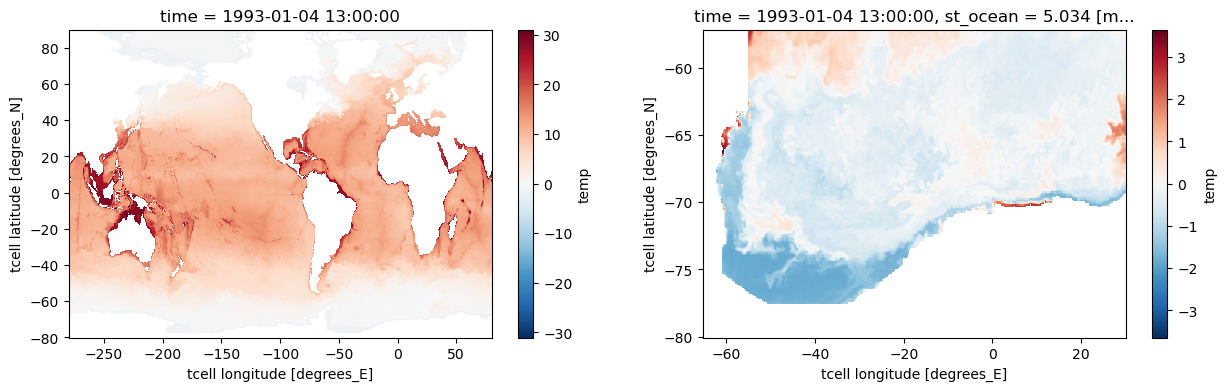

In [285]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
ocean.temp.mean('st_ocean')[0].plot(ax=ax0)
ds_wg.temp.mean('st_ocean')[0].where(mask).plot(ax=ax1);

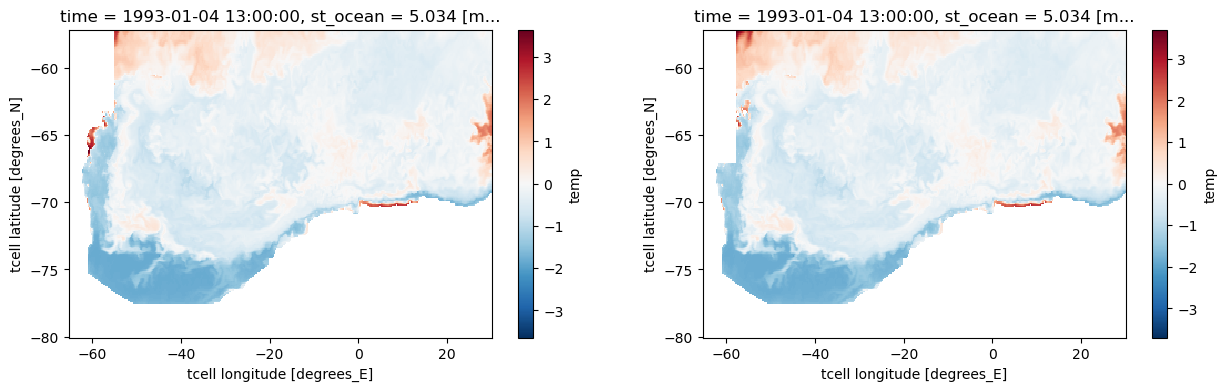

In [286]:
#use mask not mask1
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
ds_wg.temp.mean('st_ocean')[0].where(mask).plot(ax=ax0)
ds_wg.temp.mean('st_ocean')[0].where(mask1).plot(ax=ax1);

## Correcting for spikes in salt data
In late 1993, 1997 and late 2018

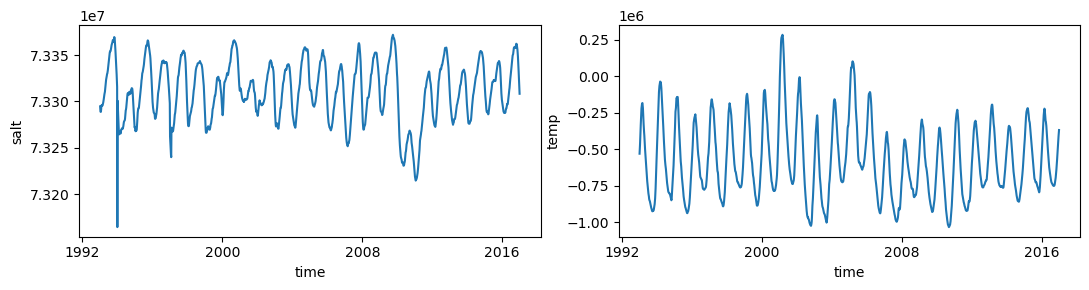

In [19]:
#spike in salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

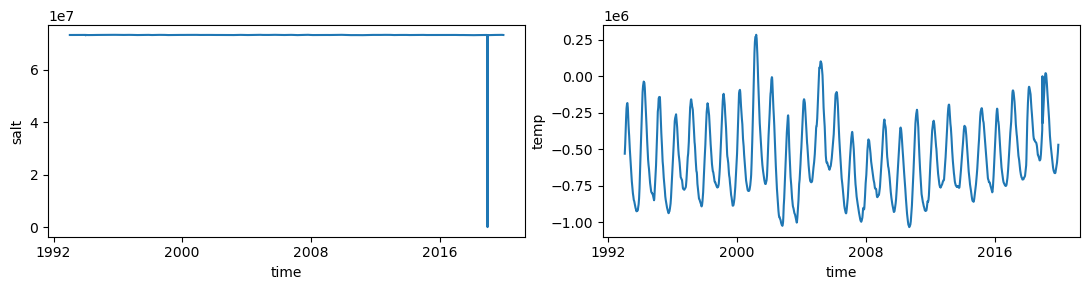

In [20]:
#another spike in salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

In [14]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp

#2018
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

#1993
salt25 = ds_wg.salt.sel(time='1993-12-25').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})
salt04 = ds_wg.salt.sel(time='1994-01-04').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})

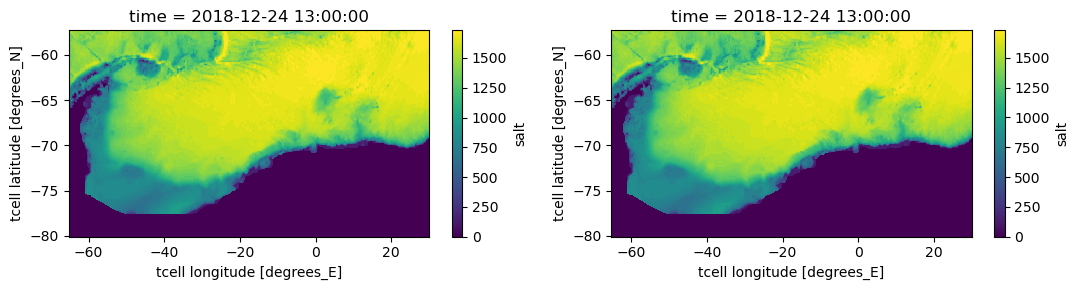

In [22]:
#plotting what each endpt date looks like - salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

salt19.salt.sum('st_ocean').plot(ax=ax0)
salt29.salt.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

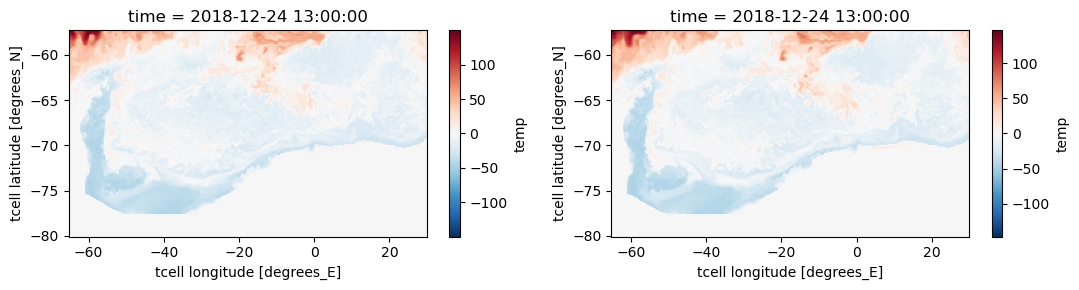

In [23]:
#plotting what each endpt date looks like - temp
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

temp19.temp.sum('st_ocean').plot(ax=ax0)
temp29.temp.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

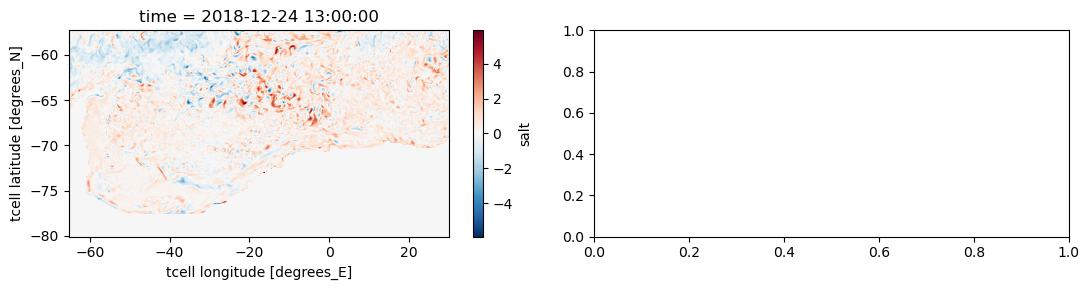

In [24]:
#plotting diff between dates - salt (left) & temp (right)
fig, (ax0,ax10) = plt.subplots(1,2, figsize=(11,3))
(salt19.salt - salt29.salt).sum('st_ocean').plot(ax=ax0)
(temp19.temp - temp29.temp).sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

In [15]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

#avging the two endpts to insert onto 1993-12-30 since there is a spike on that date due to nudging
salt30_ds = (salt25+salt04)/2
salt30 = salt30_ds.salt

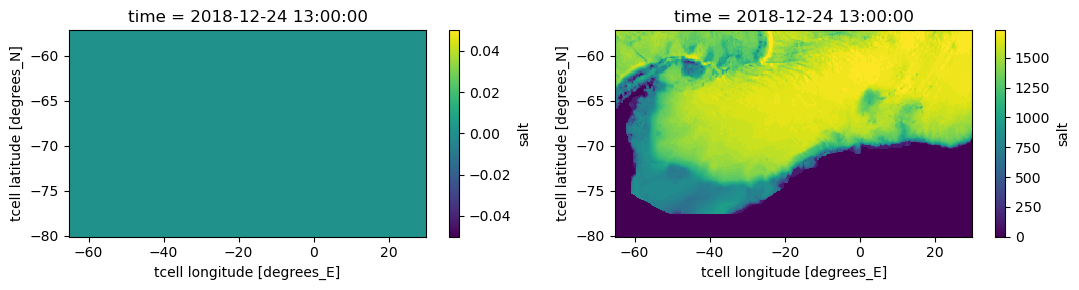

In [19]:
#plotting salt on 12-24 in ds_wg before inserting avged salt with 12-24 timestamp - salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.salt.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
salt24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

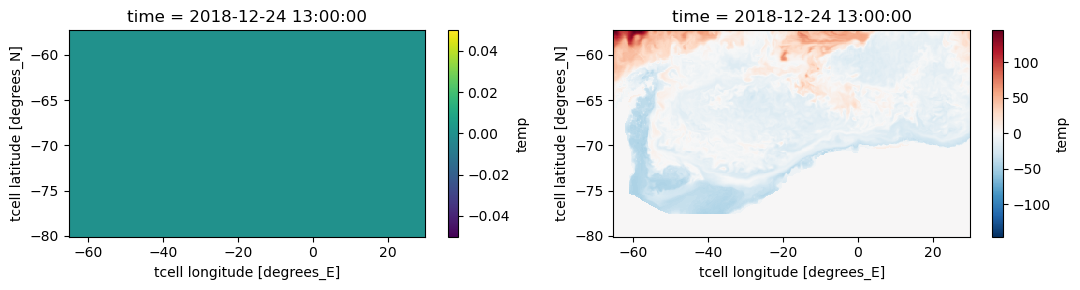

In [27]:
#plotting temp on 12-24 in ds_wg before inserting avged salt with 12-24 timestamp - temp
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.temp.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
temp24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

In [16]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

#inserting avged salt value on 1993-12-30 date into ds_wg
ds_wg['salt'][72] = salt30[0]

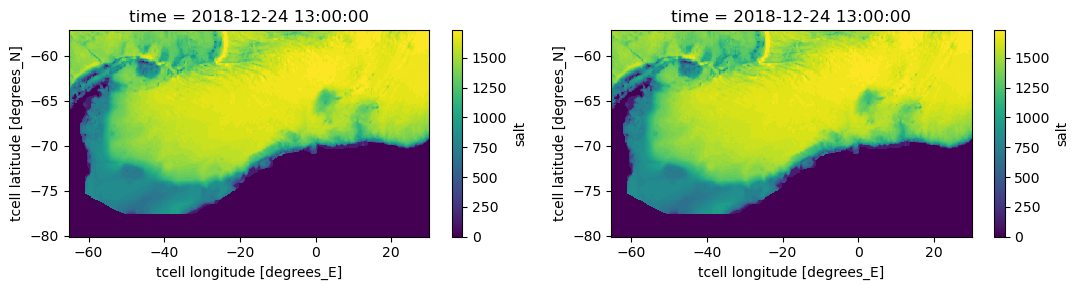

In [21]:
#success! - ds_wg.salt now has avged values of dates 12-19 & 12-29 on 12-24 - salt
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.salt.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
salt24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

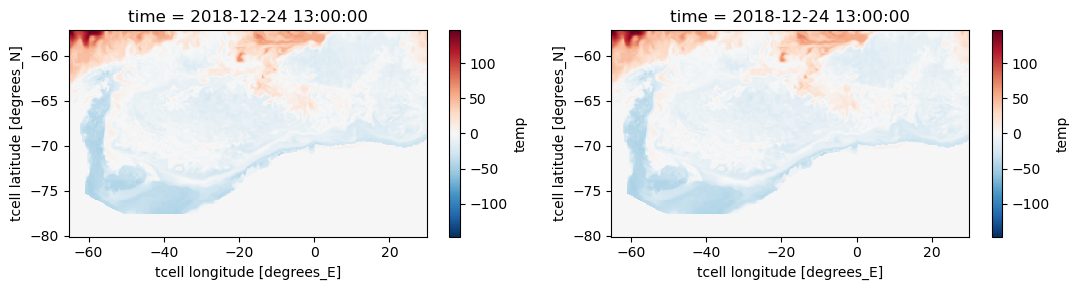

In [185]:
#success! - ds_wg.temp now has avged values of dates 12-19 & 12-29 on 12-24 - temp
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))

ds_wg.temp.sel(time='2018-12-24').sum('st_ocean').plot(ax=ax0)
temp24.sum('st_ocean').plot(ax=ax1)
plt.tight_layout();

In [17]:
#adjusting for another spike in jan1997

#going to insert avg'd values from dec & feb into jan
dec = ds_wg.salt.sel(time='1996-12')
jan = ds_wg.salt.sel(time='1997-01')
feb = ds_wg.salt.sel(time='1997-02')

#creating new jan object with avg'd values from prev and next months
for i in range(6):
    jan[i] = ((dec[i] + feb[i]) / 2)
    
jan_range = np.arange(292, 298)

#plugging new jan values into ds_wg
for i in range(6):
    for j in jan_range:
        ds_wg.salt[j] = jan[i]

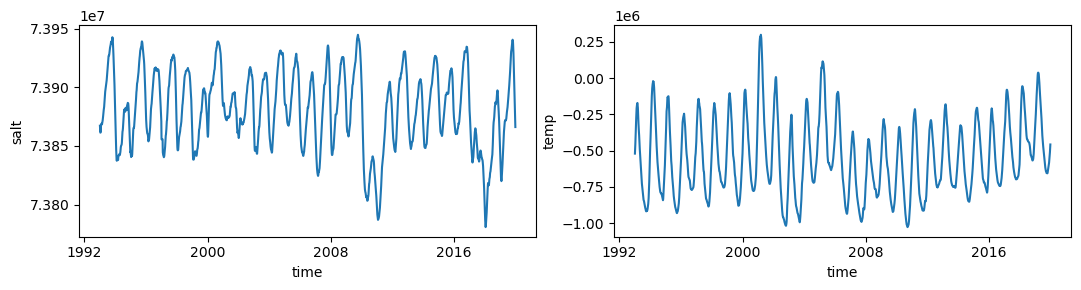

In [23]:
#checking spike again - success! no more spikes in salt or missing data in 2018
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [18]:
pref = 2000
sigma2 = fastjmd95.rho(ds_wg.salt, ds_wg.temp, pref)

In [19]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 208, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 208, 381), dtype=float64, chunksize=(1, 50, 208, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.49 -57.36 -57.23

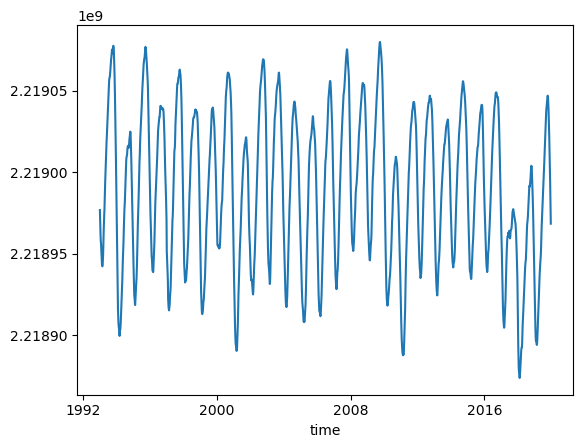

In [25]:
sigma2.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

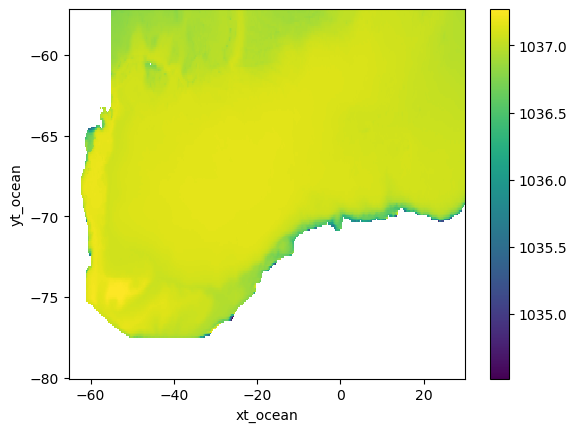

In [83]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [20]:
sigma2.nbytes/1e9

62.447424

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [25]:
fastjmd95.__version__

'0.2.1'

In [20]:
drhodt = fastjmd95.drhodt(ds_wg.salt, ds_wg.temp, pref)
drhods = fastjmd95.drhods(ds_wg.salt, ds_wg.temp, pref)

In [21]:
vol = cells.dx_interp * cells.dy_u * cells.dz

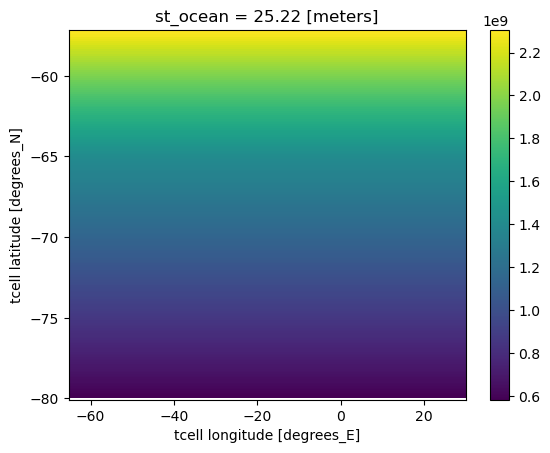

In [29]:
vol.isel(st_ocean=2).T.plot()

In [22]:
totttend_truth = (totend.totttend * drhodt[1:])# * vol)#.load()

In [23]:
totstend_truth = (totend.totstend * drhods[1:])# * vol)#.load()

In [24]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9
totend_truth = (delta_sigma * vol) / total_time

In [25]:
dt_values = (surf.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], surf.time.values[1:])}) #shaves off first time stamp in `surf.time`
surf.coords['dt'] = dt

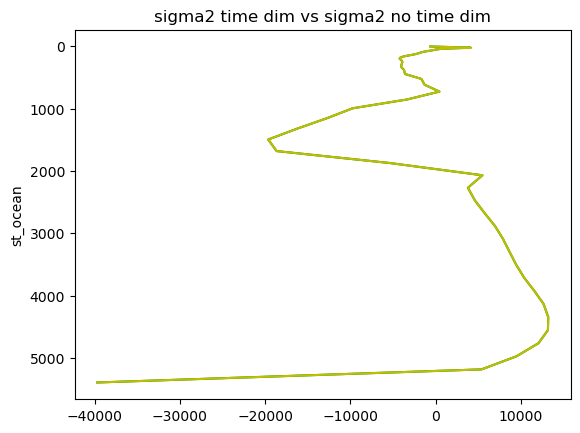

In [59]:
(sigma2.diff(dim='time')*vol/surf.dt[1:]).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

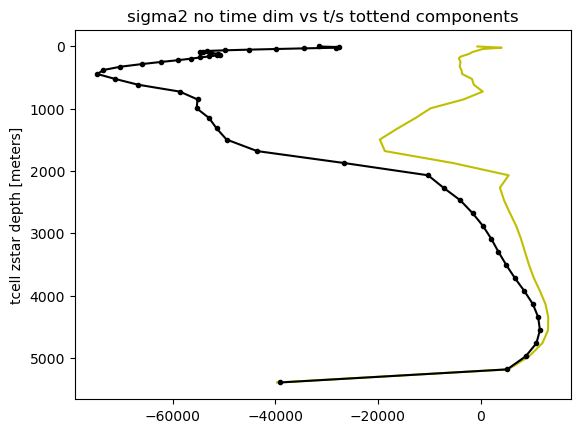

In [60]:
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

In [26]:
# out of the 3 options above, choosing tottend term to be defined as:
totend_truth = ((sigma2.diff(dim='time') * vol) / surf.dt[1:]).drop('dt')#.load()

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

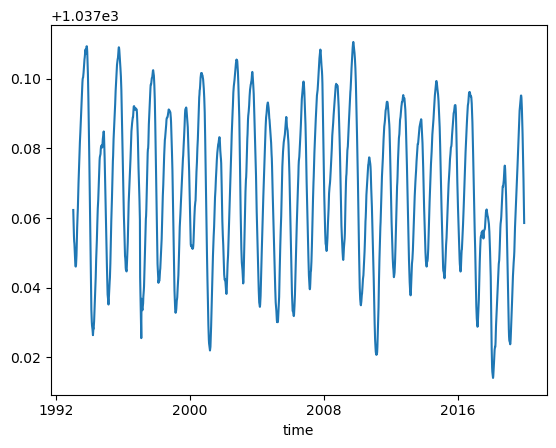

In [64]:
sigma2.sel(time=slice('1980', '2019')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

In [27]:
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [28]:
sigma_bins.size

700

In [29]:
client.restart()

<Client: 'tls://10.1.71.3:8786' processes=0 threads=0, memory=0 B>

In [30]:
#load in autoreload so you don't have to restart kernel everytime you want to run bb function
%load_ext autoreload

#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [31]:
import bb

In [32]:
#sigma2 and vol boxes

box1_sigma2 = bb.slice_box(sigma2, 41, 380, 159, 207, cell='c')
box2_sigma2 = bb.slice_box(sigma2, 30, 380, 149, 159, cell='c')
box3_sigma2 = bb.slice_box(sigma2, 16, 380, 123, 149, cell='c')
box4_sigma2 = bb.slice_box(sigma2, 1, 380, 1, 123, cell='c')

box1_vol = bb.slice_box(vol, 41, 380, 159, 207, cell='c')
box2_vol = bb.slice_box(vol, 30, 380, 149, 159, cell='c')
box3_vol = bb.slice_box(vol, 16, 380, 123, 149, cell='c')
box4_vol = bb.slice_box(vol, 1, 380, 1, 123, cell='c')

In [33]:
#sigma_dist boxes

sigma_dist1 = histogram(box1_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box1_vol, dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

sigma_dist2 = histogram(box2_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box2_vol, dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

sigma_dist3 = histogram(box3_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box3_vol, dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

sigma_dist4 = histogram(box4_sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=box4_vol, dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

In [34]:
sigma_dist = sigma_dist1 + sigma_dist2 + sigma_dist3 + sigma_dist4

In [35]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

(1037.0, 1037.3)

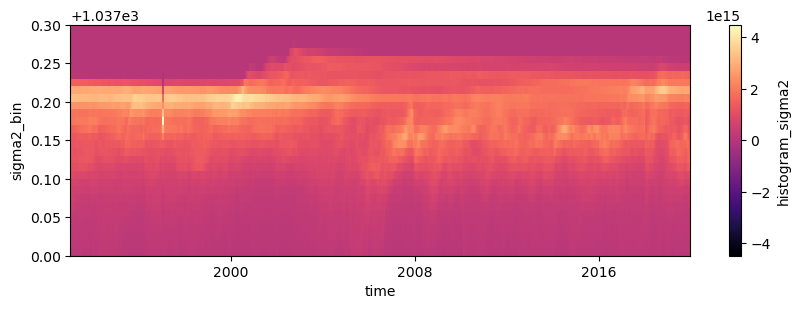

In [36]:
sigma_dist.plot(x='time', figsize=(10,3), cmap='magma')
plt.ylim(1037, 1037.3)

(1037.0, 1037.3)

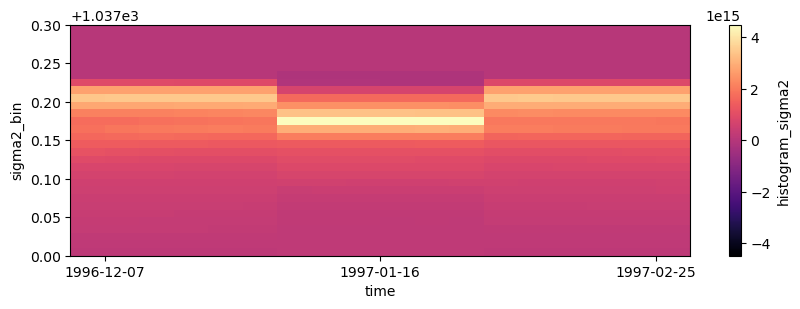

In [37]:
#01-28-1997 causing strange distribution
sigma_dist.sel(time=slice('1996-12', '1997-02')).plot(x='time', figsize=(10,3), cmap='magma')
plt.ylim(1037, 1037.3)

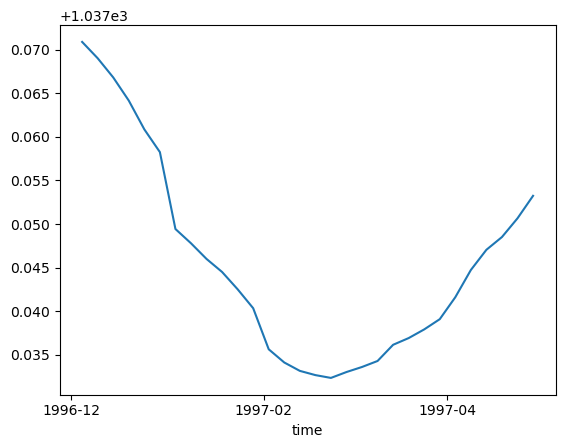

In [38]:
sigma2.sel(time=slice('1996-12', '1997-04')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

#### Adjusting for another spike in Jan of 1997 
for `sigma_dist` variables

In [39]:
#for sigma_dist
dec = sigma_dist.sel(time='1996-12')
feb = sigma_dist.sel(time='1997-02')
jan = sigma_dist.sel(time='1997-01')

#creating new jan object with avg'd values from prev and next months
for i in range(6):
    jan[i] = ((dec[i] + feb[i]) / 2)
    
jan_range = np.arange(292, 298)

#plugging new jan values into sigma_dist ds
for i in range(6):
    for j in jan_range:
        sigma_dist[j] = jan[i]

(1037.0, 1037.3)

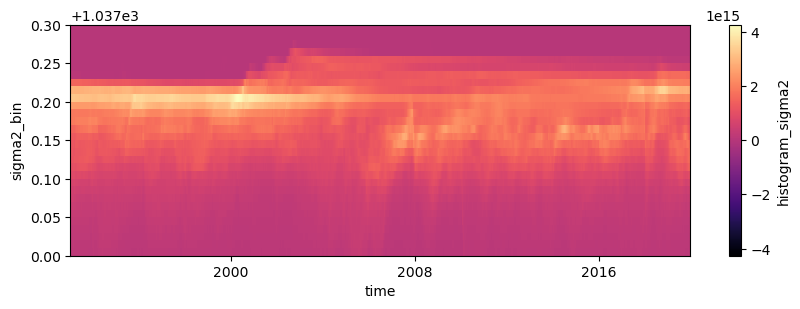

In [40]:
#got rid of spike in jan 1997
sigma_dist.plot(x='time', figsize=(10,3), cmap='magma')
plt.ylim(1037, 1037.3)

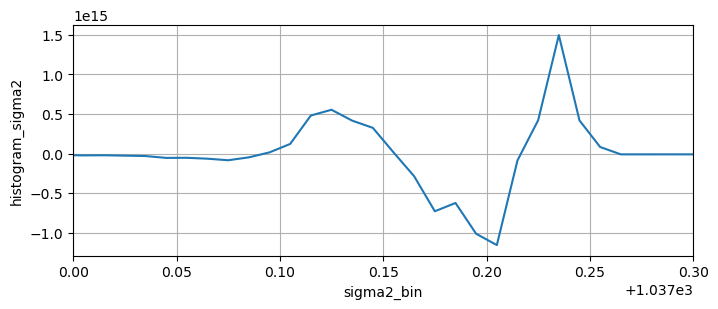

In [41]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot()
plt.xlim(1037, 1037.3)
plt.grid();

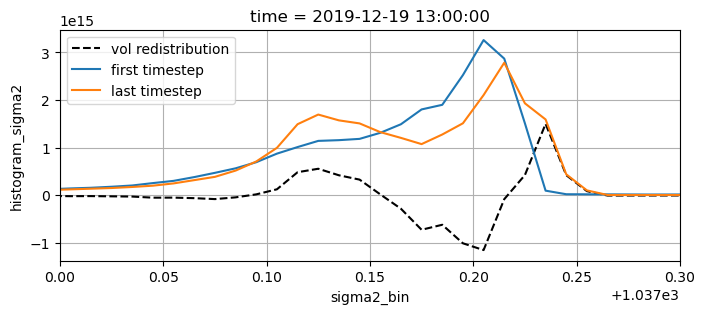

In [106]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot(color='k', label='vol redistribution', linestyle='dashed')
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037, 1037.3)
plt.grid();

## <font color='Green'>\begin{equation*} \frac{\partial \mathcal{V}}{\partial t} \end{equation*}</font>

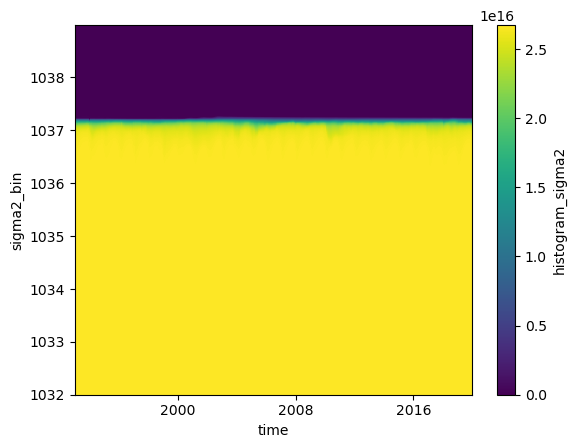

In [42]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot();
#plt.ylim(1037.5, 1036.4)

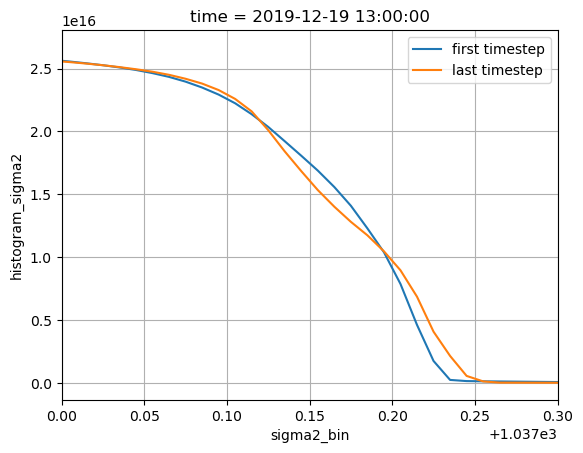

In [108]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037, 1037.3)
plt.grid();

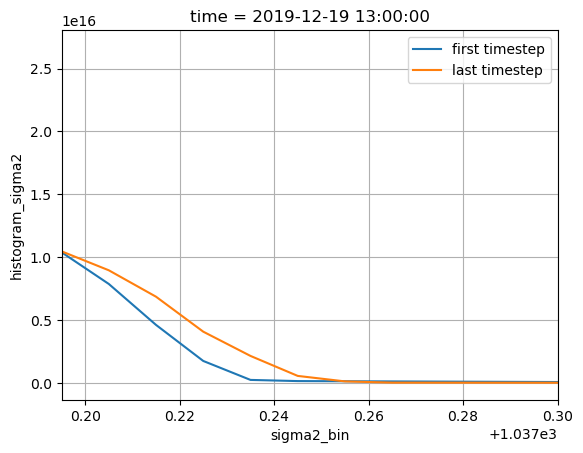

In [109]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.195, 1037.3)
plt.grid();

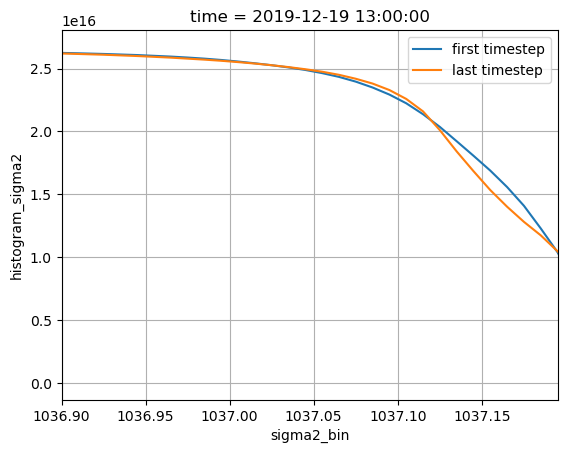

In [110]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.9, 1037.195)
plt.grid();

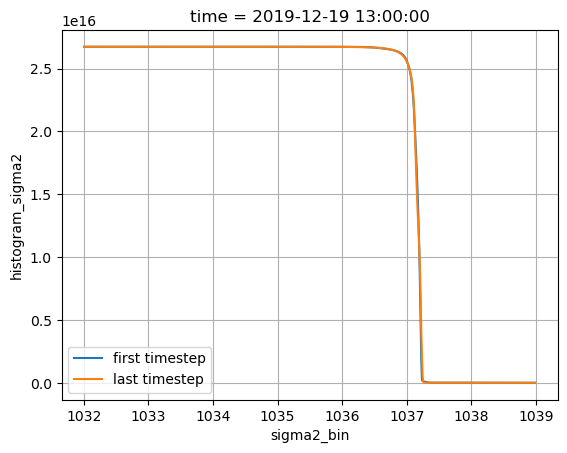

In [111]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
#plt.xlim(1037, 1037.3)
plt.grid();

In [43]:
delta_V = V.diff(dim='time')

In [44]:
dVdt = (delta_V / surf.dt[1:]).drop('dt')

In [114]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.33333333e-05, -8.33333333e-05, -8.33333333e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.77777778e-05,  2.77777778e-05,  2.77777778e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.77777778e-05,  2.77777778e-05,  2.77777778e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

(1036.0, 1037.3)

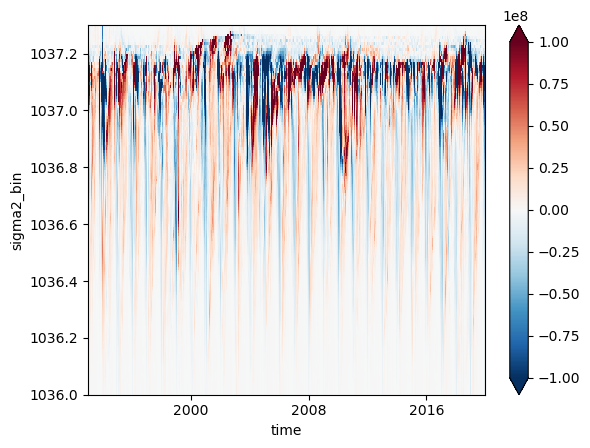

In [115]:
dVdt.plot(x='time', vmax=1e8, yincrease=False)
plt.ylim(1036, 1037.3)

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \sigma_2 \end{equation*}</font>

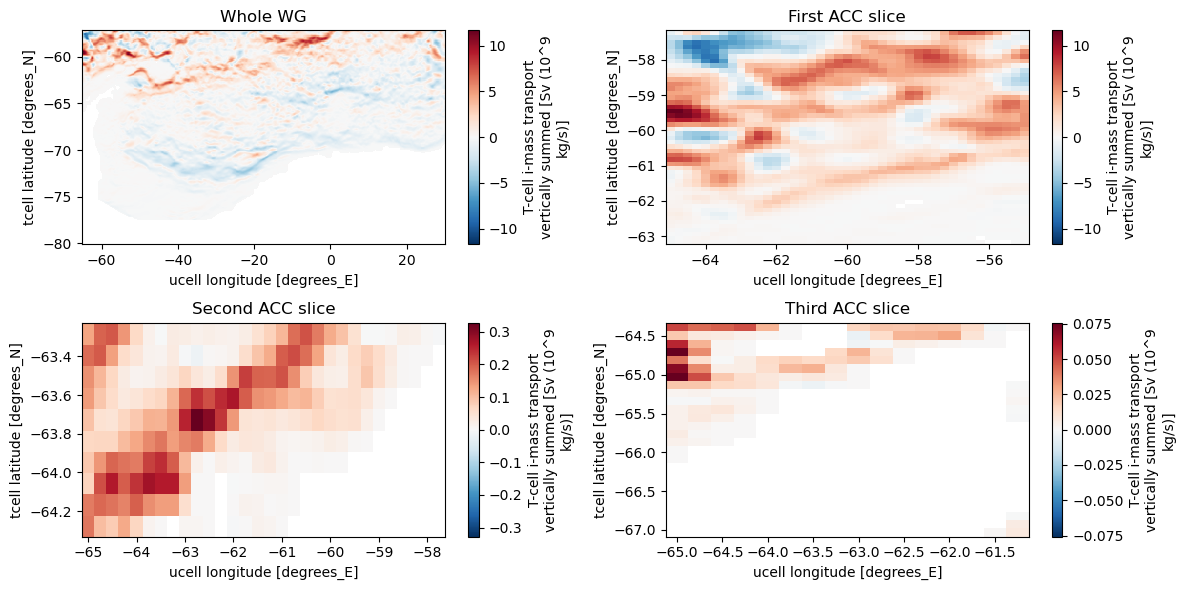

In [116]:
t = 20

fig, ax = plt.subplots(2,2, figsize=(12,6))

transport.tx_int[t].plot(ax=ax[0,0])
ax[0,0].set_title('Whole WG')
transport.tx_int[t,159:None, None:41].plot(ax=ax[0,1])
ax[0,1].set_title('First ACC slice')
transport.tx_int[t,149:159, None:30].plot(ax=ax[1,0])
ax[1,0].set_title('Second ACC slice')
transport.tx_int[t,123:149, None:16].plot(ax=ax[1,1])
ax[1,1].set_title('Third ACC slice')

plt.tight_layout();

In [45]:
client.restart()

<Client: 'tls://10.1.71.3:8786' processes=0 threads=0, memory=0 B>

In [118]:
box1 = bb.box_budget(transport.tx_int.isel(time=t), transport.ty_int.isel(time=t),  41, 380, 159, 207)
box2 = bb.box_budget(transport.tx_int.isel(time=t), transport.ty_int.isel(time=t), 30, 380, 149, 159)
box3 = bb.box_budget(transport.tx_int.isel(time=t), transport.ty_int.isel(time=t), 16, 380, 123, 149)
box4 = bb.box_budget(transport.tx_int.isel(time=t), transport.ty_int.isel(time=t), 1, 380, 1, 123)

In [119]:
residual = box1 + box2 + box3 + box4
residual.values

array(-0.00863159, dtype=float32)

In [120]:
#entire timeseries data now
box1 = bb.box_budget(transport.tx_int, transport.ty_int,  41, 380, 159, 207)
box2 = bb.box_budget(transport.tx_int, transport.ty_int, 30, 380, 149, 159)
box3 = bb.box_budget(transport.tx_int, transport.ty_int, 16, 380, 123, 149)
box4 = bb.box_budget(transport.tx_int, transport.ty_int, 1, 380, 1, 123)

In [121]:
residual = box1 + box2 + box3 + box4
residual.mean('time').values

array(-0.10021527, dtype=float32)

In [122]:
client.restart()

<Client: 'tls://10.0.34.2:8786' processes=0 threads=0, memory=0 B>

In [46]:
#right
box1_r_transport = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='right').load()
box2_r_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='right').load()
box3_r_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='right').load()
box4_r_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='right').load()

u_transport_right = (box1_r_transport.sum(('yt_ocean', 'st_ocean')) + box2_r_transport.sum(('yt_ocean', 'st_ocean')) + 
                     box3_r_transport.sum(('yt_ocean', 'st_ocean')) + box4_r_transport.sum(('yt_ocean', 'st_ocean')))

#left
box1_l_transport = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='left').load()
box2_l_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='left').load()
box3_l_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='left').load()
box4_l_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='left').load()

u_transport_left = (box1_l_transport.fillna(0.).sum(('yt_ocean', 'st_ocean')) + 
                    box2_l_transport.fillna(0.).sum(('yt_ocean', 'st_ocean')) + 
                    box3_l_transport.fillna(0.).sum(('yt_ocean', 'st_ocean')) + 
                    box4_l_transport.fillna(0.).sum(('yt_ocean', 'st_ocean')))

#upper
box1_u_transport = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='upper').load()
box2_u_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='upper').load()
box3_u_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='upper').load()
box4_u_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='upper').load()

v_transport_upper = (box1_u_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box2_u_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box3_u_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box4_u_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')))

#lower
box1_lo_transport = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='lower').load()
box2_lo_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='lower').load()
box3_lo_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='lower').load()
box4_lo_transport = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='lower').load()

v_transport_lower = (box1_lo_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box2_lo_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box3_lo_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box4_lo_transport.fillna(0.).sum(('xt_ocean', 'st_ocean')))

In [47]:
#going off of sign convention from bb.py module
residual = - u_transport_right + u_transport_left - v_transport_upper + v_transport_lower
residual.mean('time').values

array(-0.10021548, dtype=float32)

In [48]:
#northward transport
v_transport_lower.mean('time').values

array(57.032906, dtype=float32)

In [49]:
#northward transport
v_transport_upper.mean('time').values

array(122.41268, dtype=float32)

In [50]:
#eastward transport
u_transport_left.mean('time').values

array(53.852135, dtype=float32)

In [51]:
#westward transport
u_transport_right.mean('time').values

array(-11.427432, dtype=float32)

In [52]:
def interp_right_with_land(array, wet_mask):
    # there are several different ways to implement this; this is one
    
    data = wet_mask * np.nan_to_num(array)  # zeros the data on land
    data_shift = np.roll(data, 1, -1)
    
    wet_fac = wet_mask + np.roll(wet_mask, 1, -1)
    # wet_fac = 0: water on left AND right
    # wet_fac = 1: water on left OR right
    # wet_fac = 2: no land nearby
    
    # division by zero creates NaNs
    out =  1 / wet_fac * (data + data_shift)
    
    return np.nan_to_num(out)

In [53]:
wet_mask_full = sigma2.notnull().astype(np.int8)
wet_mask_full

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 208, xt_ocean: 381)>
dask.array<astype, shape=(1970, 50, 208, 381), dtype=int8, chunksize=(1, 50, 208, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.49 -57.36 -57.23

In [54]:
sigma_at_tx_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yt_ocean', 'xu_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'xu_ocean': transport.dims['xu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(xu_ocean=transport.xu_ocean)

sigma_at_ty_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yu_ocean', 'xt_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'yu_ocean': transport.dims['yu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(yu_ocean=transport.yu_ocean)


In [55]:
sigma_at_tx_full.equals(sigma_at_tx_full.where(sigma_at_tx_full.notnull()))

True

In [56]:
sigma_at_ty_full.equals(sigma_at_ty_full.where(sigma_at_ty_full.notnull()))

True

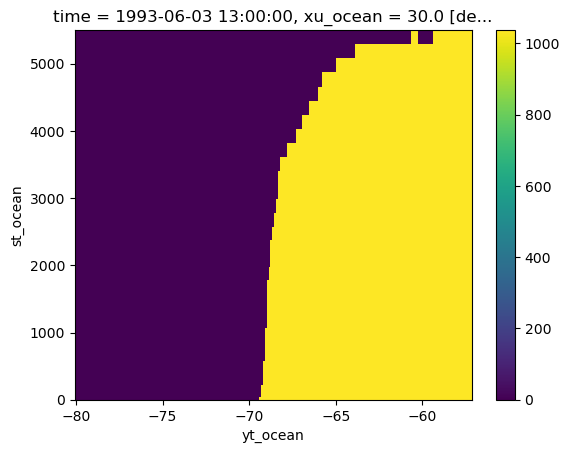

In [57]:
sigma_at_tx_full.isel(xu_ocean=-1)[30].plot()

In [58]:
client.restart()

<Client: 'tls://10.1.71.3:8786' processes=0 threads=0, memory=0 B>

In [60]:
#right
box1_r_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full,  41, 380, 159, 207, bs='right').load()
box2_r_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 30, 380, 149, 159, bs='right').load()
box3_r_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 16, 380, 123, 149, bs='right').load()
box4_r_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 1, 380, 1, 123, bs='right').load()

b1_r_sigma_interp = box1_r_sigma.interp(time=transport.time)
b2_r_sigma_interp = box2_r_sigma.interp(time=transport.time)
b3_r_sigma_interp = box3_r_sigma.interp(time=transport.time)
b4_r_sigma_interp = box4_r_sigma.interp(time=transport.time)

In [61]:
client.restart()

<Client: 'tls://10.1.71.3:8786' processes=0 threads=0, memory=0 B>

In [62]:
#left
box1_l_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 41, 380, 159, 207, bs='left').load()
box2_l_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 30, 380, 149, 159, bs='left').load()
box3_l_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 16, 380, 123, 149, bs='left').load()
box4_l_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 1, 380, 1, 123, bs='left').load()

b1_l_sigma_interp = box1_l_sigma.interp(time=transport.time)
b2_l_sigma_interp = box2_l_sigma.interp(time=transport.time)
b3_l_sigma_interp = box3_l_sigma.interp(time=transport.time)
b4_l_sigma_interp = box4_l_sigma.interp(time=transport.time)

In [63]:
client.restart()

<Client: 'tls://10.1.71.3:8786' processes=0 threads=0, memory=0 B>

In [59]:
#upper
box1_u_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full,  41, 380, 159, 207, bs='upper').load()
box2_u_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 30, 380, 149, 159, bs='upper').load()
box3_u_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 16, 380, 123, 149, bs='upper').load()
box4_u_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 1, 380, 1, 123, bs='upper').load()

b1_u_sigma_interp = box1_u_sigma.interp(time=transport.time)
b2_u_sigma_interp = box2_u_sigma.interp(time=transport.time)
b3_u_sigma_interp = box3_u_sigma.interp(time=transport.time)
b4_u_sigma_interp = box4_u_sigma.interp(time=transport.time)

In [49]:
client.restart()

<Client: 'tls://10.0.196.2:8786' processes=0 threads=0, memory=0 B>

In [64]:
#lower
box1_lo_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full,  41, 380, 159, 207, bs='lower').load()
box2_lo_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 30, 380, 149, 159, bs='lower').load()
box3_lo_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 16, 380, 123, 149, bs='lower').load()
box4_lo_sigma = bb.box_budget(sigma_at_tx_full, sigma_at_ty_full, 1, 380, 1, 123, bs='lower').load()

b1_lo_sigma_interp = box1_lo_sigma.interp(time=transport.time)
b2_lo_sigma_interp = box2_lo_sigma.interp(time=transport.time)
b3_lo_sigma_interp = box3_lo_sigma.interp(time=transport.time)
b4_lo_sigma_interp = box4_lo_sigma.interp(time=transport.time)

In [65]:
b1_r_sigma_interp.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -63.17 -63.06 -62.94 ... -57.49 -57.36 -57.23
    xu_ocean  float64 30.0
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

In [66]:
box1_r_transport.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -63.17 -63.06 -62.94 ... -57.49 -57.36 -57.23

In [67]:
# GOAL: Nothing below here uses dask at all. No dashboard. Entirely in memory.

#right
box1_rhist = histogram(b1_r_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box1_r_transport.fillna(0.), dim=['st_ocean','yt_ocean'])
box2_rhist = histogram(b2_r_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box2_r_transport.fillna(0.), dim=['st_ocean','yt_ocean'])
box3_rhist = histogram(b3_r_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box3_r_transport.fillna(0.), dim=['st_ocean','yt_ocean'])
box4_rhist = histogram(b4_r_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box4_r_transport.fillna(0.), dim=['st_ocean','yt_ocean'])

#left
box1_lhist = histogram(b1_l_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box1_l_transport.fillna(0.), dim=['st_ocean','yt_ocean'])#.load()
box2_lhist = histogram(b2_l_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box2_l_transport.fillna(0.), dim=['st_ocean','yt_ocean'])#.load()
box3_lhist = histogram(b3_l_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box3_l_transport.fillna(0.), dim=['st_ocean','yt_ocean'])#.load()
box4_lhist = histogram(b4_l_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box4_l_transport.fillna(0.), dim=['st_ocean','yt_ocean'])#.load()

#upper
box1_uhist = histogram(b1_u_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box1_u_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()
box2_uhist = histogram(b2_u_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box2_u_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()
box3_uhist = histogram(b3_u_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box3_u_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()
box4_uhist = histogram(b4_u_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box4_u_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()

#lower
box1_lohist = histogram(b1_lo_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box1_lo_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()
box2_lohist = histogram(b2_lo_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box2_lo_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()
box3_lohist = histogram(b3_lo_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box3_lo_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()
box4_lohist = histogram(b4_lo_sigma_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=box4_lo_transport.fillna(0.), dim=['st_ocean','xt_ocean'])#.load()

In [68]:
u_binned_right = box1_rhist + box2_rhist + box3_rhist + box4_rhist
u_binned_left = box1_lhist + box2_lhist + box3_lhist + box4_lhist
v_binned_upper = box1_uhist + box2_uhist + box3_uhist + box4_uhist
v_binned_lower = box1_lohist + box2_lohist + box3_lohist + box4_lohist

In [69]:
client.restart()

<Client: 'tls://10.1.71.3:8786' processes=15 threads=30, memory=450.00 GiB>

In [70]:
float((u_binned_left - u_binned_right + v_binned_lower - v_binned_upper).sum('sigma2_bin').mean(dim='time')) /1e6

-1.0021522347393831e-07

In [71]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = (u_binned_right 
           -u_binned_left 
           +v_binned_upper
           -v_binned_lower).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 985, sigma2_bin: 699)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.14375757,
        -0.14375757, -0.14375757],
       [ 0.        ,  0.        ,  0.        , ...,  0.12034992,
         0.12034992,  0.12034992],
       [ 0.        ,  0.        ,  0.        , ...,  0.1477071 ,
         0.1477071 ,  0.1477071 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.19068347,
         0.19068347,  0.19068347],
       [ 0.        ,  0.        ,  0.        , ...,  0.08309252,
         0.08309252,  0.08309252],
       [ 0.        ,  0.        ,  0.        , ...,  0.28357604,
         0.28357604,  0.28357604]])
Coordinates:
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

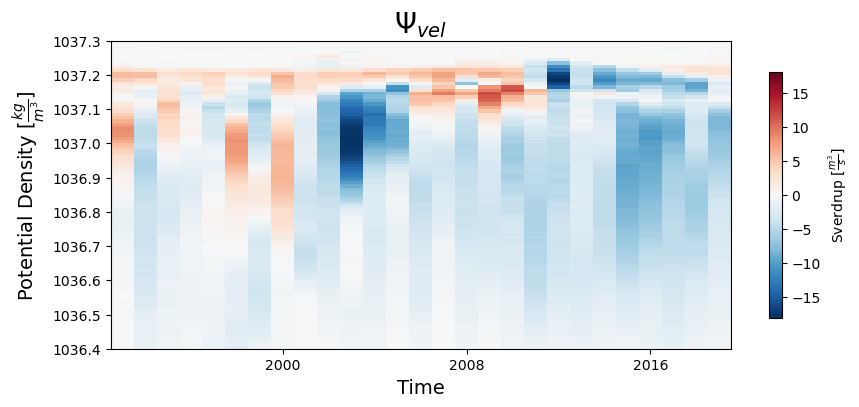

In [72]:
psi_vel.resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

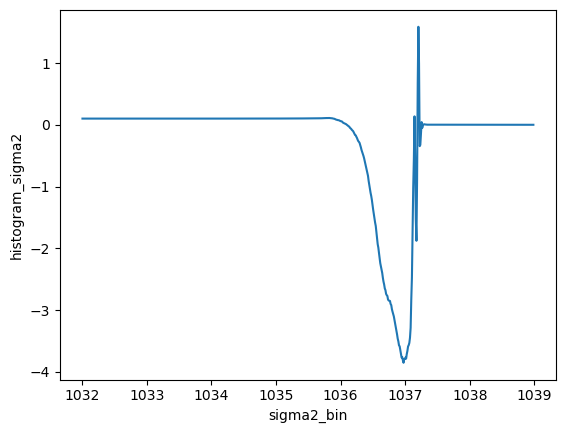

In [73]:
psi_vel.mean(dim='time').plot()
#plt.xlim(1036.5, 1037.5)

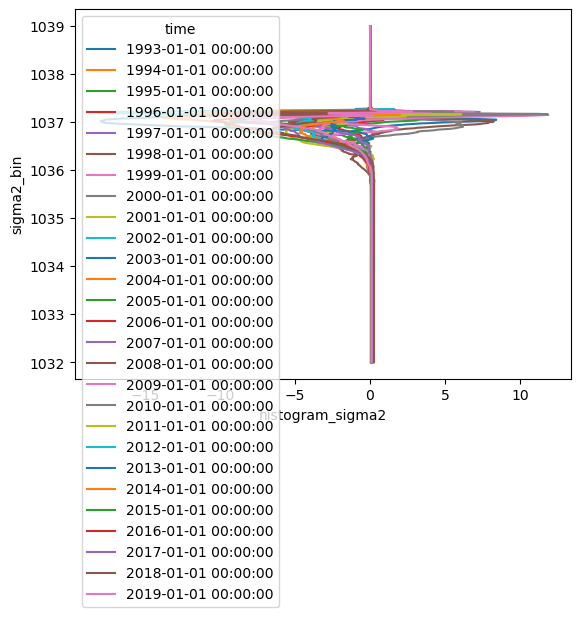

In [74]:
psi_vel.resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
#plt.ylim(1037.5, 1036.5);

# <font color='Green'>\begin{equation*} \Omega_{trans} = \frac{\partial V}{\partial t} - \Psi_{vel}\end{equation*} </font>

In [75]:
#omega_tot_interp = omega_total.interp(time=psi_vel.time)
#R1_interp = R1.interp(time=psi_vel.time)
dVdt_interp = dVdt.interp(time=psi_vel.time)

In [76]:
omega_trans = (dVdt_interp/1e6) - psi_vel

In [77]:
omega_trans.load()

<xarray.DataArray (time: 985, sigma2_bin: 699)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ..., -0.12034992,
        -0.12034992, -0.12034992],
       [ 0.        ,  0.        ,  0.        , ..., -0.1477071 ,
        -0.1477071 , -0.1477071 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.19068347,
        -0.19068347, -0.19068347],
       [ 0.        ,  0.        ,  0.        , ..., -0.08309252,
        -0.08309252, -0.08309252],
       [ 0.        ,  0.        ,  0.        , ..., -0.28357604,
        -0.28357604, -0.28357604]])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + \Omega_{trans} \end{equation*} </font>

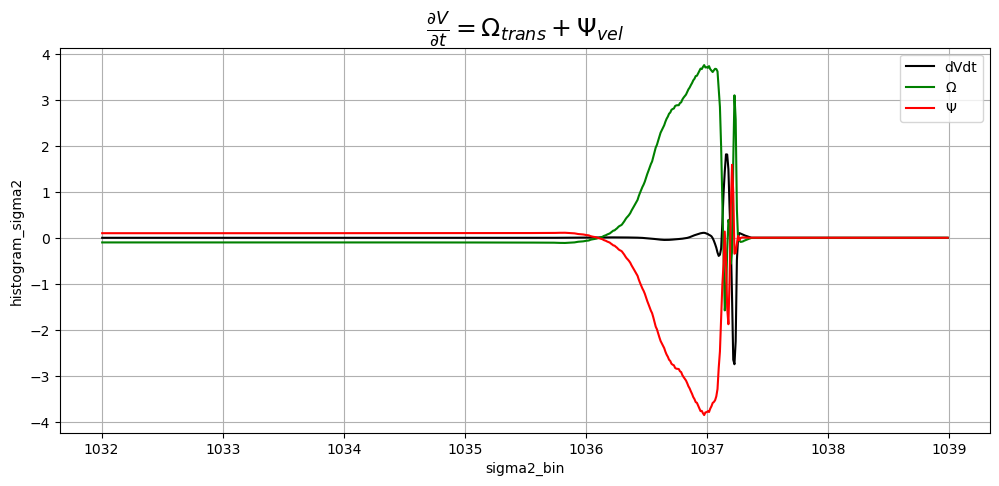

In [78]:
plt.figure(figsize=(12,5))
#(omega_tot_interp/1e6).mean(dim='time').plot(label='tottend', color='k')
(-dVdt_interp/1e6).mean(dim='time').plot(label='dVdt', color='k')
omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
#R2.mean(dim='time').plot(label='R2', color='lightgreen')
psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
#(R1_interp/1e6).mean(dim='time').plot(label='R1', color='blue', linestyle='dashed')
plt.grid()
plt.legend()
#plt.xlim(1036.5, 1037.5)
plt.title(r'$\frac{\partial V}{\partial t} = \Omega_{trans} + \Psi_{vel}$', fontsize=18);

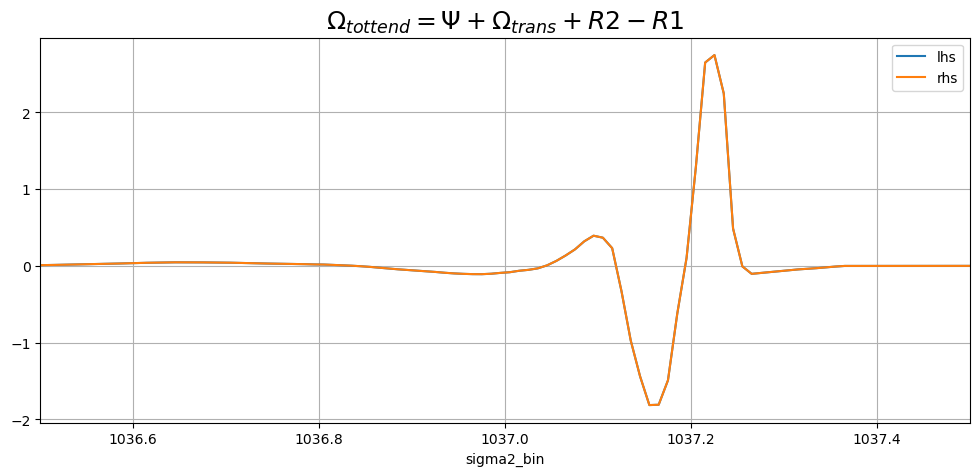

In [79]:
plt.figure(figsize=(12,5))
(dVdt_interp/1e6).mean(dim='time').plot(label='lhs')
(omega_trans + psi_vel).mean(dim='time').plot(label='rhs')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\Omega_{tottend} = \Psi + \Omega_{trans} + R2 - R1$', fontsize=18, fontweight='bold');

## Saving Data

In [80]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [81]:
transport = xr.merge([u_binned_right.rename('u_binned_right'), 
                      u_binned_left.rename('u_binned_left'),
                      v_binned_upper.rename('v_binned_upper'),
                      v_binned_lower.rename('v_binned_lower'), 
                      psi_vel.rename('psi_vel')])

In [82]:
wmt_budget_terms = xr.merge([dVdt_interp.rename('dVdt'), omega_trans.rename('omega_trans'), transport])

In [83]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_trans     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_left   (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned_upper  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned_lower  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel         (time, sigma2_bin) float64 -0.1438 -0.1438 ... 0.0 0.0

In [84]:
#uploading wmt budget terms
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/wmt_budget_terms.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

In [85]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

In [86]:
sigma2.nbytes/1e9

62.447424

In [87]:
sigma = xr.merge([sigma_dist.rename('sigma_dist'), sigma2.rename('sigma2')])

In [88]:
sigma

<xarray.Dataset>
Dimensions:     (time: 1970, sigma2_bin: 699, st_ocean: 50, xt_ocean: 381,
                 yt_ocean: 208)
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * st_ocean    (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * xt_ocean    (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean    (yt_ocean) float64 -80.02 -79.92 -79.81 ... -57.49 -57.36 -57.23
Data variables:
    sigma_dist  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sigma2      (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 50, 208, 381), meta=np.ndarray>

In [ ]:
#uploading sigma2 and sigma_dist
gcsmap_sigma = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/sigma.zarr')
sigma.to_zarr(gcsmap_sigma, mode='w')

In [192]:
client.close()
cluster.close()